# Transfer learning for computer vision
This notebook introduces the concept of transfer learning in computer vision. The problem of identifying objects in images is now considered to be mostly solved. This is due to several factors, among them the use of deep convolutional networks trained on large amounts of data. More strikingly, the intermediate layers learned by these networks can be used to solve new object recognition problems.

Here we demonstrate how the weights of the convolutional layers learned by the VGG-16 network, trained on the ImageNet data set, can help us to quickly build a strikingly accurate image classifier using a moderately sized data set.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#################################################################
# Load data
#
# This cell implements a function to load the Caltech 101 data set.
# You can find it at http://www.vision.caltech.edu/Image_Datasets/Caltech101/
# To simplify things a bit, I modified the images so that they all would be 224x224 in size
# You can find the script I used for that in the scripts/ folder (pad_ct101.py)
#################################################################
from scipy import ndimage
import os
from os import listdir
from os.path import isfile, join
import subprocess
import re
import numpy as np

WIDTH = 224
HEIGHT = 224
CHANNELS = 3

# In the paper describing the network we are going to use, 
# they say they preprocess the data by subtracting the ImageNet-wide mean
IMAGENET_RGB_MEAN = [123.68, 116.779, 103.939]    

def read_caltech101(mypath):
    num_classes = 101

    # We omit the BACKGROUND_Google class
    dirs = [f for f in listdir(mypath) if f != 'BACKGROUND_Google']

    label = 0
    label_map = dict()

    X = []
    y = []

    for dir in dirs:    
        label_map[label] = dir
        onlyfiles = [f for f in listdir(mypath+'/'+dir) if isfile(join(mypath+'/'+dir, f))]
        for f in onlyfiles:
            full_path = join(mypath+'/'+dir, f)
            img = ndimage.imread(full_path).astype(np.float32)
            # We only consider color images
            if len(img.shape)==3:
                #Preprocess according to VGG specs: subtract Imagenet RGB mean
                for i in range(3):
                    img[:,:,i] -= IMAGENET_RGB_MEAN[i]
                X.append(img)
                y.append(label)
        label += 1

    
    # Convert to numpy arrays
    X = np.concatenate(X).reshape([len(X), WIDTH, HEIGHT, CHANNELS])    
    y = np.array(y)
    return X,y,label_map    


In [3]:
import tensorflow
X, y, label_map = read_caltech101('../padded_101')

# Transform labels to one-hot vectors
num_classes = 101
y_cat = tensorflow.keras.utils.to_categorical(y, num_classes)

print ('X: {}. y: {}'.format(X.shape, y.shape))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


X: (8266, 224, 224, 3). y: (8266,)


In [4]:
for k in label_map:
    print(k, label_map[k], len(list(filter(lambda x: x==k, y))))

0 bonsai 128
1 Faces 435
2 ceiling_fan 45
3 sea_horse 57
4 binocular 32
5 okapi 39
6 sunflower 85
7 rooster 45
8 dollar_bill 50
9 anchor 41
10 nautilus 49
11 ketch 110
12 yin_yang 42
13 butterfly 86
14 wheelchair 53
15 saxophone 38
16 electric_guitar 72
17 scorpion 84
18 beaver 45
19 snoopy 31
20 cup 54
21 lamp 61
22 mayfly 35
23 crocodile 50
24 scissors 34
25 inline_skate 30
26 Motorbikes 785
27 bass 50
28 grand_piano 99
29 schooner 57
30 chair 61
31 minaret 74
32 mandolin 42
33 platypus 34
34 windsor_chair 55
35 dolphin 64
36 accordion 49
37 octopus 32
38 crayfish 68
39 kangaroo 86
40 elephant 62
41 emu 52
42 joshua_tree 62
43 garfield 31
44 buddha 81
45 barrel 45
46 crocodile_head 51
47 cannon 40
48 Leopards 200
49 brontosaurus 38
50 helicopter 86
51 lobster 40
52 car_side 0
53 umbrella 73
54 watch 239
55 starfish 81
56 pagoda 47
57 metronome 31
58 hawksbill 100
59 ferry 65
60 tick 42
61 menorah 77
62 ibis 80
63 panda 34
64 laptop 79
65 cougar_face 64
66 camera 47
67 ewer 83
68 crab

6413 airplanes


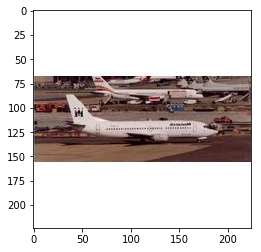

In [5]:
# Visualize the dataset
i = np.random.randint(X.shape[0])
x = np.copy(X[i])
for j in range(3):
    x[:,:,j] += IMAGENET_RGB_MEAN[j]
x=x/255.
print( i,label_map[y[i]])
plt.imshow(x, cmap='gray')

In [6]:
##################################################################
# Baseline tests:
# We will try out a relatively simple task. We'll only consider
# four classes: Airplane, motorbike, faces, leopard (the most numerous in Caltech 101)
# We'll train a couple of well-known classifiers to see how well we can do
# with a straightforward approach
#
##################################################################

In [7]:
# Filter the dataset so it only contains the two considered classes
# Warning! Make sure these indices correspond to the classes mentioned above. Check the dictionary object
classes = [0,2,3,5]
filtered_ids = list(filter(lambda i: y[i] in classes, np.arange(X.shape[0])))
X_filt = X[filtered_ids,:]
y_filt = y[filtered_ids]
len(filtered_ids)

269

In [8]:
def get_splits(X, y, ratio=0.1, cat=False):
    """
    Finds a random split of size ratio*size(data).
    Returns the corresponding splits of X and y.
    """
    val_ids = np.random.choice(np.arange(X.shape[0]), int(X.shape[0]*ratio), replace=False)
    train_ids = np.delete(np.arange(X.shape[0]), val_ids)
    x_train = X[train_ids,:]
    x_val = X[val_ids,:]
    if cat:
        y_train = y[train_ids,:]
        y_val = y[val_ids,:]
    else:
        y_train = y[train_ids]
        y_val = y[val_ids]                
    return x_train, y_train, x_val, y_val

In [9]:
from sklearn import metrics
def evaluate(y, preds, classes):
    """
    Given a set of labels y and predictions preds, computes precision, recall and F1.
    """
    for i in classes:
        preds_i = [1 if j==i else 0 for j in preds]
        y_i = [1 if j==i else 0 for j in y]
        print( 'Class {}:'.format(label_map[i])    )
        print( 'Precision: {}'.format(metrics.precision_score(y_i, preds_i)))
        print( 'Recall: {}'.format(metrics.recall_score(y_i, preds_i)))
        print( 'F1: {}'.format(metrics.f1_score(y_i, preds_i)))
        print( '')

In [10]:
###########################################################################
# Baseline tests: First, we will train a couple of well-known classifiers
# to see how a basic approach does
###########################################################################

In [11]:
# Obtain train/test splits
x_train, y_train, x_test, y_test = get_splits(X_filt, y_filt, ratio=0.1, cat=False)
print( 'Train: {}. Test: {}'.format(x_train.shape, x_test.shape))

Train: (243, 224, 224, 3). Test: (26, 224, 224, 3)


In [12]:
#====================
# Logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')

#Convert the images into 1-D vectors
x_train_shaped = x_train.reshape([x_train.shape[0], WIDTH*HEIGHT*CHANNELS])
clf.fit(x_train_shaped, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [13]:
#====================
# Random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=10)

#Convert the images into 1-D vectors
x_train_shaped = x_train.reshape([x_train.shape[0], WIDTH*HEIGHT*CHANNELS])
clf.fit(x_train_shaped, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=10, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [14]:
# Evaluate the trained classifer
classes = np.unique(y_train)
print( classes)
x_train_shaped = x_train.reshape([x_train.shape[0], WIDTH*HEIGHT*CHANNELS])
preds = clf.predict(x_train_shaped)
print( '='*50)
print( 'Train results:')
evaluate(y_train, preds, classes)
x_test_shaped = x_test.reshape([x_test.shape[0], WIDTH*HEIGHT*CHANNELS])
preds = clf.predict(x_test_shaped)
print( '='*50)
print( 'Test results:')
evaluate(y_test, preds, classes)

[0 2 3 5]
Train results:
Class bonsai:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class ceiling_fan:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class sea_horse:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class okapi:
Precision: 1.0
Recall: 1.0
F1: 1.0

Test results:
Class bonsai:
Precision: 0.7368421052631579
Recall: 0.875
F1: 0.7999999999999999

Class ceiling_fan:
Precision: 0.75
Recall: 0.75
F1: 0.75

Class sea_horse:
Precision: 0.0
Recall: 0.0
F1: 0.0

Class okapi:
Precision: 0.5
Recall: 0.5
F1: 0.5



9
Prediction: ceiling_fan. Confidence: 0.45
Label: ceiling_fan


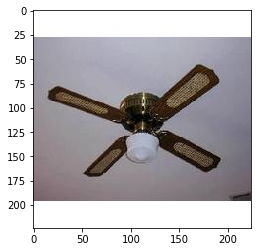

In [22]:
# Sanity check: predict random digits from the train/test set
# This way we can check visually if our classifier is well trained
import matplotlib.image as mpimg
check_set = x_test
check_y = y_test

i = np.random.choice(np.arange(check_set.shape[0]))
print( i)
img = np.copy(check_set[i])
x = np.copy(img.reshape([1, 224*224*3]))
for j in range(3):
    img[:,:,j] += IMAGENET_RGB_MEAN[j]
print( 'Prediction: {}. Confidence: {}'.format(label_map[int(clf.predict(x))], np.max(clf.predict_proba(x))))
print( 'Label: {}'.format(label_map[check_y[i]]))
img /= 255.
plt.imshow(img,cmap='gray')

In [23]:
# Import test images
# Here we load a bunch of images we got off the Internet (stored in test_imgs), 
# to see how well our classifier does in the wild.
# These were images I downloaded and saved in a local directory, so you'll have to do that yourself.
# If you want to, download a bunch of (preferrably square) images from the net and scale them to 224x224
# Notice that reusing convolutional nets is not so restrictive, as the convolutional filters can be applied to any
# input size.
# Remember the test I did: I took screenshots from youtube videos and fed them to the classifier. That way I could be
# sure that neither my classifier nor the VGG16 net had ever seen those, so no trick.
from os import listdir
from os.path import isfile, join
directory = '../test_imgs'
files = [[i,k] for i,j,k in os.walk(directory) if k]
test_imgs = ['{}/{}'.format(i[0],j) for i in files for j in i[1]]
print( test_imgs)

['../test_imgs/bonsai/1 (copy).jpg', '../test_imgs/bonsai/1.jpg']


In [24]:
i = 0

Prediction: ceiling_fan. Confidence: 0.38


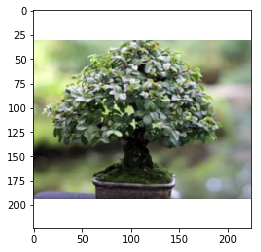

In [25]:
# Predict images taken from the internet
import matplotlib.image as mpimg
img=mpimg.imread(test_imgs[i])
i+=1
x = np.array([img]).astype(np.float32)
for j in range(3):
    x[0,:,:,j] -= IMAGENET_RGB_MEAN[j]
x=x.reshape([1, 224*224*3])
print( 'Prediction: {}. Confidence: {}'.format(label_map[int(clf.predict(x))], np.max(clf.predict_proba(x))))
plt.imshow(img,cmap='gray')

In [27]:
###########################################################################
# Transfer learning
# We now adopt an alternative approach. We will take a very deep network trained on ImageNet
# (a data set of about 14M images) and remove the uppermost layers (the classifier). We will
# then train a classifier of our own.
#
# Take into account that if we take all the classes in Caltech 101, the classifier will not be as accurate.
# Some classes are not numerous enough and there is a considerable amount of variability to correctly learn 101 of them.
# However, remember we only tried a logistic regression model in the course. You can also stack a dense neural network
# on top of VGG-16. Perhaps you can do better with that approach in the full 101-class data set.
###########################################################################

In [28]:
# Load VGG-16 trained on ImageNet
# Look at the arguments: 
# - we don't include the top of the network (i.e. we remove the classifier). We just want to 
# keep the feature extractors learned in the hidden layers. 
# - We also choose the imagenet weights, because we want to benefit from what was learned by the authors
#
# More info:
# - https://keras.io/applications/#vgg16
# - https://arxiv.org/pdf/1409.1556.pdf
from  tensorflow.python.keras import applications
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Flatten
num_classes=4
pt_model = applications.vgg16.VGG16(include_top=False, 
                                        weights='imagenet', 
                                        input_shape=(224,224,3), 
                                        pooling=None, 
                                        classes=num_classes)

In [29]:
# Print the network architecture
# Notice how big the network is (and we removed the classifier on top, which is by far the most complex part)
# For some reason not yet fully understood, deep neural networks can estimate millions of parameters "correctly"
# if they have enough data
pt_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [30]:
#Convert to Sequential (because it's what we've seen in the course, 
# but the functional API is more convenient for this purpose)
model = Sequential()
for l in pt_model.layers:
    model.add(l)
model.set_weights(pt_model.get_weights())

# We add a flattening layer in order to train a classifier on the top
model.add(Flatten())

In [32]:
# Transform training and validation sets to feature space (the representation learned by the pretrained net)
print( 'Predicting train')
x_train_rep = model.predict(x_train, verbose=1)
print( 'Predicting validation')
x_test_rep = model.predict(x_test, verbose=1)
print( x_train_rep.shape, x_test_rep.shape)

Predicting train
243/243 [==============================] - 8s 33ms/step
Predicting validation
26/26 [==============================] - 3s 98ms/step
(243, 25088) (26, 25088)


In [33]:
#####################################################
# Train a logistic regression model on feature space
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
x_train_shaped = np.array(x_train_rep).reshape([x_train_rep.shape[0], 7*7*512])
clf.fit(x_train_shaped, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
classes = np.unique(y_train)
print( classes)
preds = clf.predict(x_train_shaped)
print( '* Train results:')
evaluate(y_train, preds, classes)
x_test_shaped = x_test_rep.reshape([x_test_rep.shape[0], 7*7*512])
preds = clf.predict(x_test_shaped)
print( '* Test results:')
evaluate(y_test, preds, classes)

[0 2 3 5]
* Train results:
Class bonsai:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class ceiling_fan:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class sea_horse:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class okapi:
Precision: 1.0
Recall: 1.0
F1: 1.0

* Test results:
Class bonsai:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class ceiling_fan:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class sea_horse:
Precision: 1.0
Recall: 1.0
F1: 1.0

Class okapi:
Precision: 1.0
Recall: 1.0
F1: 1.0



In [37]:
i=0

Prediction: bonsai. Confidence: 0.9999991023125485


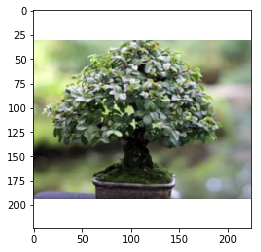

In [39]:
# Predict random images with logistic regression on feature space
import matplotlib.image as mpimg
img=mpimg.imread(test_imgs[i])
i+=1
x = np.array([img]).astype(np.float32)
for j in range(3):
    x[0,:,:,j] -= IMAGENET_RGB_MEAN[j]
x=model.predict(x).reshape([1, 7*7*512])
prediction = np.argmax(clf.predict(x))

print( 'Prediction: {}. Confidence: {}'.format(label_map[int(clf.predict(x))], np.max(clf.predict_proba(x))))
plt.imshow(img,cmap='gray')

We can also train a deep neural network on top of the VGG-16 features. In fact, for more complex tasks, that
can be much better than a simple logistic regression classifier.

There are various ways we can do this. We can place the classifier on top of the VGG network and freeze the VGG layes (see Keras API). Alternatively, we can train the classifier on the transformed inputs and then stacked the resulting (trained) network on top of VGG. This way we make the transformation+classification in one step (model.predict(x)).

In [41]:
########################################################
# Classifier on top of VGG-16

from tensorflow.python.keras.layers import Dense, Dropout

input_shape = [7*7*512,]
num_classes = 101

clf = Sequential()
clf.add(Dense(256, input_shape=input_shape, activation='relu'))
clf.add(Dropout(0.25))
clf.add(Dense(64, activation='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(num_classes, activation='softmax'))

In [42]:
########################################################
# Classifier on top of VGG-16

input_shape = [7*7*512,]
num_classes = 101

clf = Sequential()
clf.add(Dense(256, input_shape=input_shape, activation='relu'))
clf.add(Dropout(0.25))
clf.add(Dense(128, activation='relu'))
clf.add(Dropout(0.25))
clf.add(Dense(64, activation='relu'))
clf.add(Dropout(0.25))
clf.add(Dense(64, activation='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(num_classes, activation='softmax'))

In [46]:
clf.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [47]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
__________

In [49]:
# Remember: the last layer is softmax, so we need to transform the labels into one-hot vectors
y_train_cat = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tensorflow.keras.utils.to_categorical(y_test, num_classes)

In [50]:
train_loss = []
val_loss = []

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

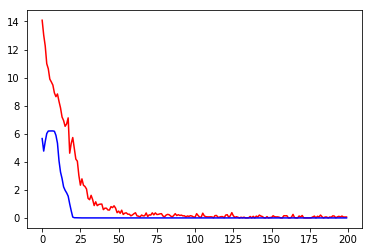

In [55]:
# Train and monitor progress
fig = plt.figure()
ax = fig.gca()

x_train_shaped = x_train_rep.reshape([x_train_rep.shape[0],7*7*512])
x_test_shaped = x_test_rep.reshape([x_test_rep.shape[0],7*7*512])
                                     
for i in range(50):
    print( i,end=', ')
    history = clf.fit(x_train_shaped, y_train_cat, epochs=1, batch_size=128, verbose=0, validation_data=(x_test_shaped, y_test_cat))
    
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    ax.clear()    
    ax.plot(train_loss, color='red', label='Train')
    ax.plot(val_loss, color='blue', label='Validation')

    fig.canvas.draw()        